In [ ]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
import pickle 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, Normalizer, PolynomialFeatures

In [116]:
df = pd.read_parquet('train_opti.parquet')

In [85]:
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression





def optimize_memory_usage(df, print_size=True):
    # Function optimizes memory usage in dataframe.
    # (RU) Функция оптимизации типов в dataframe.

    # Types for optimization.
    # Типы, которые будем проверять на оптимизацию.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Memory usage size before optimize (Mb).
    # (RU) Размер занимаемой памяти до оптимизации (в Мб).
    before_size = df.memory_usage().sum() / 1024 ** 2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
                    # Memory usage size after optimize (Mb).
    # (RU) Размер занимаемой памяти после оптимизации (в Мб).
    after_size = df.memory_usage().sum() / 1024 ** 2
    if print_size: print(
        'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(before_size, after_size, 100 * (
                    before_size - after_size) / before_size))
    return df

optimize_memory_usage(df)

Memory usage size: before 1008.9265 Mb - after 1008.9265 Mb (0.0%).


,id,target,sample_ml_new,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1,1761,1759,85,105469,191,46,0,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1,1761,1759,120,105610,144,71,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,890,1759,141,105227,191,11,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1,1599,966,30,102441,191,8,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1,1761,1759,85,104006,191,2,0,...,0,0,7642,0,0,0,0,0,0,7642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693036,693036,0,1,1761,1759,141,410,191,2,125,...,0,0,0,0,0,0,0,0,0,0
693038,693038,0,1,1761,1759,0,170,191,1,125,...,0,0,0,0,0,51714,0,0,0,0
693039,693039,0,1,1761,1759,0,168,191,1,125,...,0,0,0,0,0,51714,0,0,0,0
693040,693040,0,1,1761,1759,141,74,191,1,125,...,0,0,0,0,0,51714,0,0,0,0


In [118]:
for i in df.columns:
    proc = df[i].value_counts(normalize=True) * 100
    if i != 'target' and 80 < proc[:3].sum() < 100 and len(df[i].unique()) > 10:
        se = proc[:1].index.tolist()
        df[i] = df[i].replace(se, [-1])
        df[i] = df[i].replace([-1], [1])
        # создаем маску для значений, которые хотим заменить
        mask = ~df[i].isin([1])
        # заменяем значения, которые не входят в values_to_keep на 'new_value'
        df.loc[mask, i] = 0
    elif i != 'target' and 70 < proc[:1].sum() and len(df[i].unique()) > 10:
        se = proc[:1].index.tolist()
        df[i] = df[i].replace(se, [-1])
        mask = ~df[i].isin([1])
        df.loc[mask, i] = 0
df.drop(columns = ['id', 'sample_ml_new'],  inplace= True)

In [119]:
target = 'target'
X = df.loc[:, df.columns != target]
y = df.loc[:, target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42, stratify=y)


classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

model = CatBoostClassifier(random_state= 42,
                           class_weights = class_weights,
                           learning_rate = 0.03,
                           iterations = 3000,
                           custom_loss = ['AUC'],
                           boosting_type = 'Plain',
                           leaf_estimation_method = 'Newton',
                           random_strength = 1,
                           early_stopping_rounds = 300,
                           task_type="GPU",  
                          )
model.fit(X_train, 
          y_train, 
          plot = True,
          silent = True,
          eval_set = (X_test,  y_test),
         )
y_pred = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


Text(0.5, 1.0, 'Feature Importance')

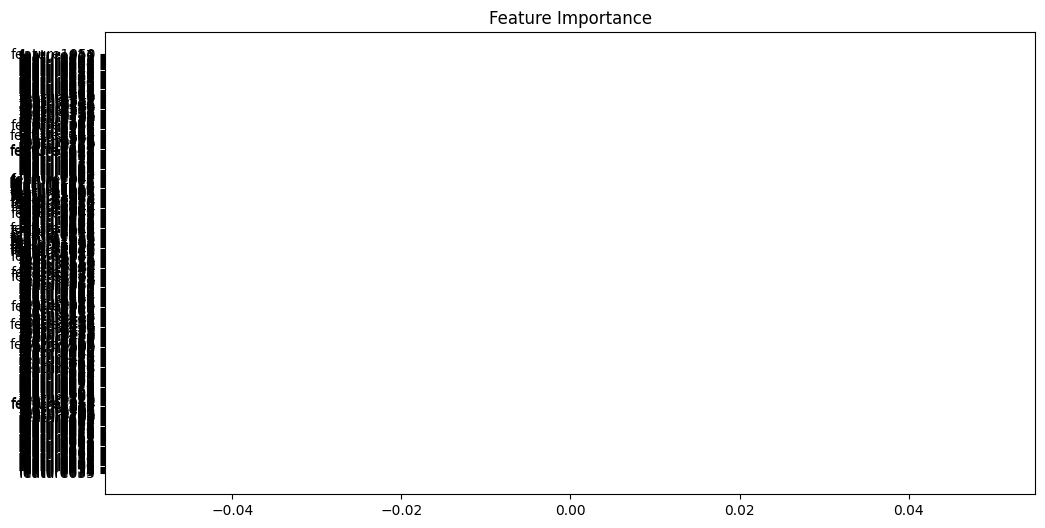

In [120]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
sexy = sorted_idx[1:400:1]

plt.barh(range(len(sexy)), feature_importance[sexy], align='center')
plt.yticks(range(len(sexy)), np.array(X_test.columns)[sexy])
plt.title('Feature Importance')

In [121]:
df.drop(columns = [*np.array(X_test.columns)[sexy]], inplace = True)

In [122]:
len(df.columns)

676

In [123]:
target = 'target'
X = df.loc[:, df.columns != target]
y = df.loc[:, target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42, stratify=y)


classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

params = {'iterations': 500, 'learning_rate': 0.06452148758550945, 'max_depth': 6, 'l2_leaf_reg': 9, 'scale_pos_weight': 4, 'bagging_temperature': 1, 'min_data_in_leaf': 89, 'eval_metric' : 'AUC','task_type': 'GPU',}
model = CatBoostClassifier(**params)
model.fit(X_train, 
          y_train,
          plot = True,
          silent = True,
          eval_set = (X_test,  y_test)
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [124]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

In [125]:
# Удаляем столбцы содержащие nan
df = pd.read_parquet('test_sber.parquet')
id = df['id']
df.drop(columns = 'id', inplace = True)

In [126]:
# procent = df.isnull().sum()/len(df) * 100
# procent.sort_values()
# df.drop(columns = ['feature756', 'feature642'], inplace = True)

In [127]:
df = df[[
 'feature1',
 'feature2',
 'feature3',
 'feature4',
 'feature5',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature13',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature18',
 'feature19',
 'feature20',
 'feature21',
 'feature22',
 'feature23',
 'feature24',
 'feature25',
 'feature26',
 'feature27',
 'feature28',
 'feature29',
 'feature30',
 'feature31',
 'feature32',
 'feature33',
 'feature34',
 'feature35',
 'feature36',
 'feature37',
 'feature38',
 'feature39',
 'feature40',
 'feature41',
 'feature42',
 'feature43',
 'feature44',
 'feature45',
 'feature46',
 'feature47',
 'feature48',
 'feature49',
 'feature50',
 'feature51',
 'feature52',
 'feature53',
 'feature54',
 'feature55',
 'feature56',
 'feature57',
 'feature58',
 'feature59',
 'feature60',
 'feature61',
 'feature62',
 'feature63',
 'feature64',
 'feature65',
 'feature66',
 'feature67',
 'feature68',
 'feature69',
 'feature70',
 'feature71',
 'feature72',
 'feature73',
 'feature74',
 'feature75',
 'feature76',
 'feature77',
 'feature78',
 'feature79',
 'feature80',
 'feature81',
 'feature82',
 'feature83',
 'feature84',
 'feature85',
 'feature86',
 'feature87',
 'feature88',
 'feature89',
 'feature90',
 'feature91',
 'feature92',
 'feature93',
 'feature94',
 'feature95',
 'feature96',
 'feature97',
 'feature98',
 'feature99',
 'feature100',
 'feature101',
 'feature102',
 'feature103',
 'feature104',
 'feature105',
 'feature106',
 'feature107',
 'feature108',
 'feature109',
 'feature112',
 'feature114',
 'feature115',
 'feature116',
 'feature117',
 'feature118',
 'feature119',
 'feature120',
 'feature121',
 'feature122',
 'feature123',
 'feature124',
 'feature125',
 'feature126',
 'feature127',
 'feature128',
 'feature129',
 'feature130',
 'feature131',
 'feature132',
 'feature133',
 'feature134',
 'feature135',
 'feature136',
 'feature137',
 'feature138',
 'feature139',
 'feature140',
 'feature141',
 'feature142',
 'feature143',
 'feature144',
 'feature145',
 'feature146',
 'feature147',
 'feature148',
 'feature149',
 'feature150',
 'feature151',
 'feature152',
 'feature153',
 'feature154',
 'feature155',
 'feature156',
 'feature157',
 'feature158',
 'feature159',
 'feature160',
 'feature161',
 'feature162',
 'feature163',
 'feature164',
 'feature165',
 'feature166',
 'feature167',
 'feature168',
 'feature169',
 'feature170',
 'feature171',
 'feature172',
 'feature173',
 'feature174',
 'feature175',
 'feature176',
 'feature177',
 'feature178',
 'feature179',
 'feature180',
 'feature181',
 'feature182',
 'feature183',
 'feature184',
 'feature185',
 'feature186',
 'feature187',
 'feature188',
 'feature189',
 'feature190',
 'feature191',
 'feature192',
 'feature193',
 'feature194',
 'feature195',
 'feature196',
 'feature197',
 'feature198',
 'feature199',
 'feature200',
 'feature201',
 'feature202',
 'feature203',
 'feature204',
 'feature205',
 'feature206',
 'feature207',
 'feature208',
 'feature209',
 'feature210',
 'feature211',
 'feature212',
 'feature213',
 'feature214',
 'feature215',
 'feature216',
 'feature217',
 'feature218',
 'feature219',
 'feature220',
 'feature221',
 'feature222',
 'feature223',
 'feature224',
 'feature225',
 'feature226',
 'feature227',
 'feature228',
 'feature229',
 'feature230',
 'feature231',
 'feature232',
 'feature233',
 'feature234',
 'feature235',
 'feature236',
 'feature237',
 'feature238',
 'feature239',
 'feature240',
 'feature241',
 'feature242',
 'feature243',
 'feature244',
 'feature245',
 'feature246',
 'feature247',
 'feature248',
 'feature249',
 'feature250',
 'feature251',
 'feature252',
 'feature253',
 'feature254',
 'feature255',
 'feature256',
 'feature257',
 'feature258',
 'feature259',
 'feature260',
 'feature261',
 'feature262',
 'feature263',
 'feature264',
 'feature265',
 'feature266',
 'feature267',
 'feature268',
 'feature269',
 'feature270',
 'feature271',
 'feature272',
 'feature274',
 'feature282',
 'feature284',
 'feature285',
 'feature286',
 'feature287',
 'feature288',
 'feature289',
 'feature290',
 'feature291',
 'feature292',
 'feature293',
 'feature294',
 'feature295',
 'feature296',
 'feature297',
 'feature298',
 'feature299',
 'feature300',
 'feature301',
 'feature302',
 'feature303',
 'feature304',
 'feature305',
 'feature306',
 'feature307',
 'feature308',
 'feature309',
 'feature310',
 'feature311',
 'feature312',
 'feature313',
 'feature314',
 'feature315',
 'feature316',
 'feature317',
 'feature318',
 'feature319',
 'feature320',
 'feature321',
 'feature322',
 'feature323',
 'feature324',
 'feature325',
 'feature326',
 'feature327',
 'feature328',
 'feature329',
 'feature330',
 'feature331',
 'feature332',
 'feature333',
 'feature334',
 'feature335',
 'feature336',
 'feature337',
 'feature338',
 'feature339',
 'feature340',
 'feature341',
 'feature342',
 'feature343',
 'feature344',
 'feature345',
 'feature346',
 'feature347',
 'feature348',
 'feature349',
 'feature350',
 'feature351',
 'feature352',
 'feature353',
 'feature354',
 'feature355',
 'feature356',
 'feature357',
 'feature358',
 'feature359',
 'feature360',
 'feature361',
 'feature362',
 'feature363',
 'feature364',
 'feature365',
 'feature366',
 'feature367',
 'feature368',
 'feature369',
 'feature370',
 'feature371',
 'feature372',
 'feature373',
 'feature374',
 'feature375',
 'feature376',
 'feature377',
 'feature378',
 'feature379',
 'feature380',
 'feature382',
 'feature384',
 'feature385',
 'feature397',
 'feature402',
 'feature405',
 'feature409',
 'feature414',
 'feature416',
 'feature426',
 'feature434',
 'feature435',
 'feature436',
 'feature437',
 'feature440',
 'feature441',
 'feature443',
 'feature444',
 'feature445',
 'feature446',
 'feature448',
 'feature449',
 'feature450',
 'feature451',
 'feature452',
 'feature453',
 'feature455',
 'feature457',
 'feature459',
 'feature461',
 'feature462',
 'feature463',
 'feature464',
 'feature467',
 'feature469',
 'feature470',
 'feature472',
 'feature474',
 'feature475',
 'feature477',
 'feature479',
 'feature480',
 'feature481',
 'feature482',
 'feature483',
 'feature486',
 'feature487',
 'feature488',
 'feature489',
 'feature491',
 'feature493',
 'feature494',
 'feature495',
 'feature497',
 'feature499',
 'feature501',
 'feature503',
 'feature504',
 'feature505',
 'feature506',
 'feature507',
 'feature508',
 'feature509',
 'feature510',
 'feature513',
 'feature515',
 'feature516',
 'feature517',
 'feature518',
 'feature519',
 'feature523',
 'feature525',
 'feature526',
 'feature527',
 'feature529',
 'feature530',
 'feature531',
 'feature532',
 'feature533',
 'feature534',
 'feature535',
 'feature537',
 'feature538',
 'feature540',
 'feature543',
 'feature545',
 'feature546',
 'feature547',
 'feature551',
 'feature552',
 'feature553',
 'feature554',
 'feature559',
 'feature560',
 'feature564',
 'feature572',
 'feature573',
 'feature577',
 'feature587',
 'feature588',
 'feature590',
 'feature600',
 'feature601',
 'feature602',
 'feature605',
 'feature606',
 'feature607',
 'feature608',
 'feature609',
 'feature610',
 'feature614',
 'feature615',
 'feature622',
 'feature623',
 'feature628',
 'feature631',
 'feature637',
 'feature642',
 'feature643',
 'feature648',
 'feature651',
 'feature653',
 'feature656',
 'feature659',
 'feature667',
 'feature668',
 'feature670',
 'feature672',
 'feature674',
 'feature675',
 'feature676',
 'feature687',
 'feature688',
 'feature690',
 'feature693',
 'feature695',
 'feature704',
 'feature706',
 'feature708',
 'feature713',
 'feature714',
 'feature715',
 'feature717',
 'feature718',
 'feature719',
 'feature724',
 'feature726',
 'feature730',
 'feature733',
 'feature739',
 'feature741',
 'feature743',
 'feature749',
 'feature750',
 'feature751',
 'feature754',
 'feature755',
 'feature758',
 'feature766',
 'feature777',
 'feature779',
 'feature780',
 'feature781',
 'feature782',
 'feature783',
 'feature792',
 'feature794',
 'feature795',
 'feature799',
 'feature800',
 'feature810',
 'feature811',
 'feature812',
 'feature814',
 'feature815',
 'feature822',
 'feature827',
 'feature828',
 'feature833',
 'feature853',
 'feature854',
 'feature856',
 'feature857',
 'feature858',
 'feature859',
 'feature860',
 'feature861',
 'feature862',
 'feature863',
 'feature864',
 'feature865',
 'feature868',
 'feature869',
 'feature870',
 'feature871',
 'feature872',
 'feature873',
 'feature874',
 'feature875',
 'feature879',
 'feature881',
 'feature883',
 'feature890',
 'feature892',
 'feature893',
 'feature894',
 'feature896',
 'feature898',
 'feature899',
 'feature900',
 'feature901',
 'feature906',
 'feature907',
 'feature908',
 'feature909',
 'feature911',
 'feature913',
 'feature915',
 'feature916',
 'feature917',
 'feature918',
 'feature919',
 'feature920',
 'feature922',
 'feature923',
 'feature927',
 'feature928',
 'feature930',
 'feature931',
 'feature933',
 'feature934',
 'feature935',
 'feature936',
 'feature938',
 'feature939',
 'feature940',
 'feature941',
 'feature942',
 'feature943',
 'feature944',
 'feature945',
 'feature946',
 'feature947',
 'feature948',
 'feature949',
 'feature950',
 'feature951',
 'feature952',
 'feature953',
 'feature954',
 'feature985',
 'feature986',
 'feature987',
 'feature988',
 'feature989',
 'feature990',
 'feature991',
 'feature992',
 'feature993',
 'feature994',
 'feature995',
 'feature996',
 'feature997',
 'feature998',
 'feature999',
 'feature1000',
 'feature1001',
 'feature1002',
 'feature1003',
 'feature1004',
 'feature1034',
 'feature1035',
 'feature1036',
 'feature1037',
 'feature1038',
 'feature1039',
 'feature1040',
 'feature1041',
 'feature1042',
 'feature1043',
 'feature1044',
 'feature1045',
 'feature1046',
 'feature1047',
 'feature1048',
 'feature1049',
 'feature1050',
 'feature1051',
 'feature1052',
 'feature1053',
 'feature1054',
 'feature1055',
 'feature1056',
 'feature1057',
 'feature1058',
 'feature1059',
 'feature1060',
 'feature1061',
 'feature1065',
 'feature1066',
 'feature1067',
 'feature1068',
 'feature1069',
 'feature1070',
 'feature1071',
 'feature1072',
 'feature1073',
 'feature1074',
 'feature1076']]

In [128]:
len(df.columns)

677

In [129]:
# # Дропаем const столбцы
# df.drop(columns = 'sample_ml_new', inplace = True)
# for i in df.columns:
#     if df[i].nunique() == 1:
#         df.drop(columns = i, inplace = True)

In [130]:
for i in df.columns:
    proc = df[i].value_counts(normalize=True) * 100
    if i != 'target' and 80 < proc[:3].sum() < 100 and len(df[i].unique()) > 10:
        se = proc[:1].index.tolist()
        df[i] = df[i].replace(se, [-1])
        df[i] = df[i].replace([-1], [1])
        # создаем маску для значений, которые хотим заменить
        mask = ~df[i].isin([1])
        # заменяем значения, которые не входят в values_to_keep на 'new_value'
        df.loc[mask, i] = 0
    elif i != 'target' and 70 < proc[:1].sum() and len(df[i].unique()) > 10:
        se = proc[:1].index.tolist()
        df[i] = df[i].replace(se, [-1])
        mask = ~df[i].isin([1])
        df.loc[mask, i] = 0

C:\Users\Oleeeg\AppData\Local\Temp\ipykernel_17988\2289562976.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  if i != 'target' and 80 < proc[:3].sum() < 100 and len(df[i].unique()) > 10:
C:\Users\Oleeeg\AppData\Local\Temp\ipykernel_17988\2289562976.py:11: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  elif i != 'target' and 70 < proc[:1].sum() and len(df[i].unique()) > 10:


In [131]:
y_pred = model.predict(df)
predict_proba = model.predict_proba(df)

y = pd.DataFrame(y_pred).rename(columns = {0: 'target_bin'})
# proba = pd.DataFrame(np.amax(predict_proba, 1)).rename(columns = {0: 'target_prob'})
proba = pd.DataFrame(predict_proba[:,1]).rename(columns = {0: 'target_prob'})
id = pd.DataFrame(id)

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 110 should be feature with name feature111 (found feature114).

In [ ]:
predict_proba[:,1]

In [ ]:
submit = pd.concat([id, y, proba], axis = 1)
submit.to_csv('submit.csv')

In [ ]:
submit

In [82]:
model = CatBoostClassifier().load_model('new_cat.cbm')